In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import copy
import time

from joblib import load
from timeit import default_timer
from torch.nn import DataParallel
from util.prep_data import InputNormalizer
from util.loss_func import LpLoss
from util.HNO_GNO import UNO3D
from util.load_data import get_chunk_data_surf
from util.figplot import plot_fwi_result
from util.fwi import auto_diff_FWI, laplacian_reg

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda')
device_ids = [0]

In [2]:
eps = 0
fs = 20
fn = fs / 2  # Nyquist frequency
dt = 1 / fs
start_time_in_seconds = -0.5
end_time_in_seconds = 2.0
T = round((end_time_in_seconds - start_time_in_seconds) / dt + 1)
n_after_padding = T
freqs = torch.arange(n_after_padding // 2 + 1) * fs / (n_after_padding - 1)
ws = 2 * torch.pi * freqs
freq_to_keep = list(range(5, torch.where(freqs>=6)[0][0].item() + 1))
NF = len(freq_to_keep)

nx, ny, nz = 64, 64, 64
x, y, z = torch.linspace(0, 5000, nx), torch.linspace(0, 5000, ny), torch.linspace(0, 5000, nz)
xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

in_channels = 5
out_channels = 6
width = 32
nsrc = 30

In [17]:




    
    


'''def scatter_3D(fig, X, Y, Z, data, index, cmap, iplot, title, vmin, vmax, num_ticks=3, if_clb=False, ncover=None, shade=False):
    kw = {'cmap': cmap,
          's': 1,
          'vmin': vmin,
          'vmax': vmax}
    
    ax = fig.add_subplot(iplot[0], iplot[1], iplot[2], projection='3d', facecolor='white')
        
    ax.set_title(title, fontsize=15)

    C = ax.scatter(X[index].flatten(), Y[index].flatten(), Z[index].flatten(), c=data[index].flatten(), **kw)

    if shade:
        data[ncover == 0] = 1e10
        C1 = ax.scatter(X[index].flatten(), Y[index].flatten(), Z[index].flatten(), c=data[index].flatten(), **kw)
        C1.cmap.set_over('0.4', alpha=0.5)
        
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
    
    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3, linestyle='--')
    ax.plot([(xmin+xmax)/2, (xmin+xmax)/2], [(ymin+ymax)/2, (ymin+ymax)/2], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmax], [(ymin+ymax)/2, (ymin+ymax)/2], [(zmin+zmax)/2, (zmin+zmax)/2], **edges_kw)
    ax.plot([(xmin+xmax)/2, (xmin+xmax)/2], [ymin, ymax], [(zmin+zmax)/2, (zmin+zmax)/2], **edges_kw)
    
    ax.axis('off')
    ax.set_aspect('equal')
    ax.invert_zaxis()
    if if_clb:
        clb = plt.colorbar(C, ax=ax, fraction=0.025, pad=0.001)
        clb.ax.tick_params(labelsize=15)
        clb.locator = plt.MaxNLocator(num_ticks)
        clb.update_ticks()
    
    ax.view_init(azim=225)'''
        
'''def plot_fwi_result(srcxyz, vs, vp, vs_inv, vp_inv, index, ncover=None, shade=False):
    vs = vs / 1000
    vp = vp / 1000
    vs_inv = vs_inv / 1000
    vp_inv = vp_inv / 1000
    
    vpmax = np.percentile(vp, 99)
    vpmin = np.percentile(vp, 1)
    vsmax = np.percentile(vs, 99)
    vsmin = np.percentile(vs, 1)
    
    fig = plt.figure(figsize=(12, 8), facecolor='white')

    ax0 = fig.add_subplot(231, projection='3d', facecolor='white')
    ax0.scatter(srcxyz[:, 0]/1000, srcxyz[:, 1]/1000, srcxyz[:, 2]/1000, marker='*', color='r', s=20)
    ax0.scatter(xx[:, :, 0].flatten()/1000, yy[:, :, 0].flatten()/1000, zz[:, :, 0].flatten()/1000, 
                marker='^', color='b', s=1, alpha=0.3)
        
    ax0.set_xlabel("X (km)", fontsize=12)
    ax0.set_ylabel("Y (km)", fontsize=12)
    ax0.set_zlabel("Z (km)", fontsize=12)
    ax0.tick_params(labelsize=12)
    ax0.set_title("Source", fontsize=15)
    ax0.set_xlim(0, 5)
    ax0.set_ylim(0, 5)
    ax0.set_zlim(0, 5)
    ax0.set_box_aspect([1, 1, 1])
    ax0.invert_zaxis()
    ax0.view_init(azim=225)
    ax0.text2D(0, 0.9, "Z (km)", transform=ax0.transAxes, ha='left', va='top', fontsize=12)

    scatter_3D(fig, xx, yy, zz, vs, index, 'Spectral', (2, 3, 2), "True $\mathregular{V_S}$ (km/s)", vsmin, vsmax, 4, True)
    scatter_3D(fig, xx, yy, zz, vp, index, 'Spectral', (2, 3, 3), "True $\mathregular{V_P}$ (km/s)", vpmin, vpmax, 3, True)
    scatter_3D(fig, xx, yy, zz, vs_inv, index, 'Spectral', (2, 3, 5), "Inverted $\mathregular{V_S}$ (km/s)", vsmin, vsmax, 4, True, ncover, shade)
    scatter_3D(fig, xx, yy, zz, vp_inv, index, 'Spectral', (2, 3, 6), "Inverted $\mathregular{V_P}$ (km/s)", vpmin, vpmax, 3, True, ncover, shade)'''
    



    

In [5]:
model = UNO3D(in_channels+3, width, pad=0)
model.to(device)
model = DataParallel(model, device_ids=device_ids)
model.load_state_dict(torch.load("../model/HNO_GNO_3D.pth"))

x_standardizer = load("../model/x_standardizer_surf.sav")
y_standardizer = load("../model/y_standardizer_surf.sav")


In [7]:
data_in, data_out = get_chunk_data_surf(offset=0, chunk_size=nsrc,
                                        NF=NF, nx=nx, ny=ny, nz=nz, in_channels=in_channels, out_channels=out_channels,
                                        inputpath="../data/input_S", 
                                        outputpath="../data/output_S")
vp = copy.deepcopy(data_in[0, :, :, :, 0])
vp = vp * (x_standardizer.std[0].unique().item() + x_standardizer.eps) + x_standardizer.mean[0].unique().item()
vs = copy.deepcopy(data_in[0, :, :, :, 1])
vs = vs * (x_standardizer.std[1].unique().item() + x_standardizer.eps) + x_standardizer.mean[1].unique().item()
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        data_in,
        data_out),
    batch_size=16,
    shuffle=True)

In [8]:
fwi = auto_diff_FWI().to(device)
optimizer = torch.optim.Adam(fwi.parameters(), lr=0.03)


In [9]:
L2 = LpLoss(p=2, size_average=False)  
L1 = LpLoss(p=1, size_average=False)

lam = 1e-4  # coefficient of Laplacian regularization

nepoch = 50
loss_inv = np.zeros(nepoch)
rel_l2_inv = np.zeros(nepoch)

fwi.train()
model.eval()
for i in range(nepoch):
    t1 = default_timer()
    
    inv_loss = 0.0
    inv_rel_l2 = 0.0
    for x, y in data_loader:
        x, y = x.to(device), y[:, :, :, 0, :].to(device)
        optimizer.zero_grad()
        out = fwi(x, model)[:, :, :, 0, :]
        L2_loss = L2(out, y)
        L1_loss = L1(out, y)
        loss = 0.9 * L1_loss + 0.1 * L2_loss
        
        reg = 0
        for param in fwi.parameters():
            reg += laplacian_reg(param)
        
        loss += lam * reg
        loss.backward()
        optimizer.step()
        inv_loss += loss.item() 
        inv_rel_l2 += L2_loss.item() 
    
    loss_inv[i] = inv_loss / data_in.shape[0]
    rel_l2_inv[i] = inv_rel_l2 / data_in.shape[0]


0 33.193550538271666 0.24656389193101363 0.2448613784529946
1 31.759699136018753 0.14009958252762303 0.13439056945569589
2 31.770648263860494 0.11242560401107325 0.106922196077578
3 31.844957666937262 0.10021820574095755 0.09509865659655947
4 31.898383252788335 0.09519987286943378 0.0901133681788589
5 31.969025232829154 0.09020042726487824 0.0850962555769718
6 31.873406373895705 0.08716058405962858 0.08213193813959757
7 31.688383742701262 0.08485833894122731 0.07985088445923545
8 31.744262157008052 0.08344376213622816 0.07828034523761633
9 31.702719578985125 0.08236154498475971 0.07716666189107028
10 31.70167132699862 0.08087256370168744 0.07573025407213153
11 31.662438394967467 0.08064060590483925 0.07544985684481534
12 31.837492187973112 0.08030201666282885 0.07498982151349386
13 31.84738661441952 0.0790182144352884 0.07372863581686309
14 31.742845308035612 0.07885376485911283 0.07348322597416965
15 31.688189823180437 0.07861574039314732 0.07317108818978975
16 31.75015599420294 0.077

Text(0, 0.5, 'Relative loss')

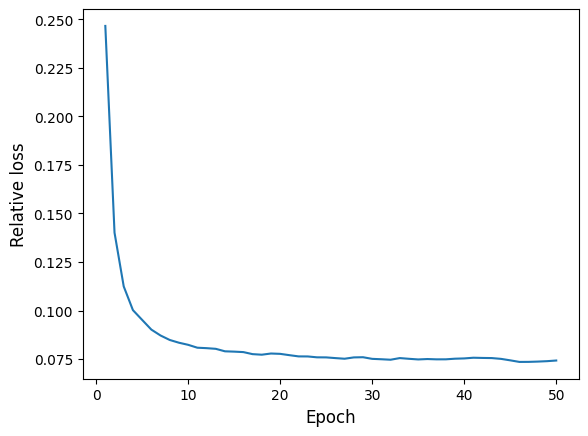

In [10]:
plt.figure()
plt.plot(range(1, len(loss_inv)+1), loss_inv)
plt.xlabel("Epoch", fontsize=12)
_=plt.ylabel("Relative loss", fontsize=12)

In [11]:
vs_inv, vp_inv = list(fwi.parameters())[0].cpu().detach().numpy(), list(fwi.parameters())[1].cpu().detach().numpy()
vs_inv = vs_inv * (x_standardizer.std[1].unique().item() + x_standardizer.eps) + x_standardizer.mean[1].unique().item()
vp_inv = vp_inv * (x_standardizer.std[0].unique().item() + x_standardizer.eps) + x_standardizer.mean[0].unique().item()

srcxyz = np.zeros((nsrc, 3))
for i in range(nsrc):
    srcxyz[i] = np.load("/net/ghisallo/scratch1/czou/fwi/freq/src_fwi_surf{}.npy".format(i))


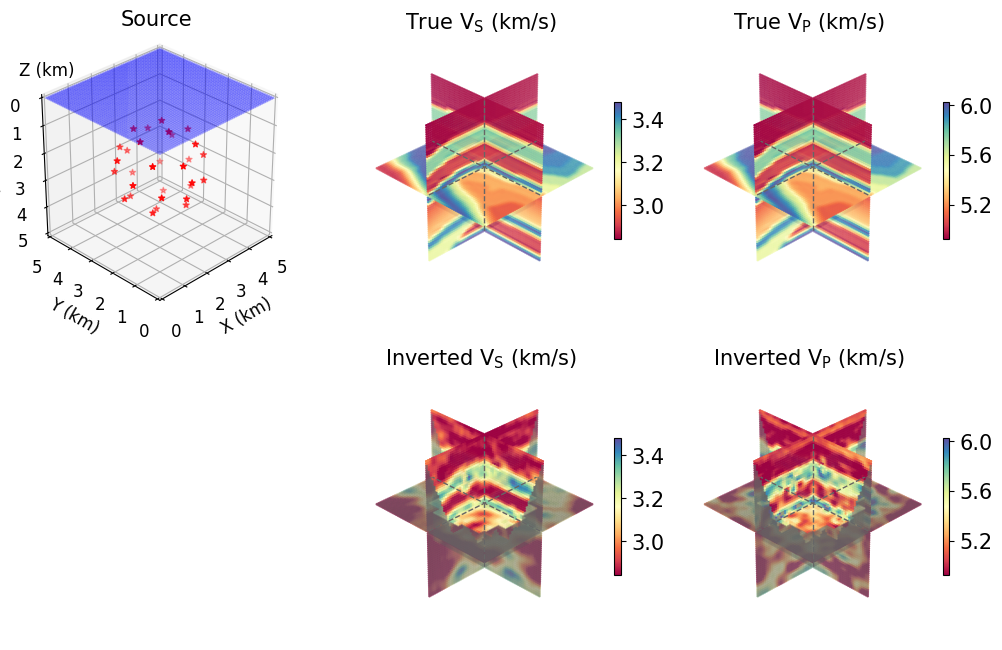

In [18]:
ncover = np.load("../data/ray_coverage.npy")
index = ((xx.numpy() == xx.unique()[nx//2].item()) | (yy.numpy() == yy.unique()[ny//2].item())| (zz.numpy() == zz.unique()[nz//2].item()))
plot_fwi_result(srcxyz, vs, vp, vs_inv, vp_inv, index, ncover, shade=True)

In [15]:
print(L2(torch.from_numpy(vp_inv[ncover>0]).unsqueeze(0), vp[ncover>0].unsqueeze(0)))
print(L2(torch.from_numpy(vs_inv[ncover>0]).unsqueeze(0), vs[ncover>0].unsqueeze(0)))

tensor(0.0256)
tensor(0.0282)


In [16]:
print(L2(torch.from_numpy(vp_inv).unsqueeze(0), vp.unsqueeze(0)))
print(L2(torch.from_numpy(vs_inv).unsqueeze(0), vs.unsqueeze(0)))

tensor(0.0613)
tensor(0.0659)
